# 1D wavefunction propagation examples

This notebook contains various 1D wavefuncton examples.

In [645]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
from matplotlib.colors import rgb_to_hsv
from matplotlib.colors import hsv_to_rgb
from matplotlib.patches import Polygon

# from matplotlib.colors import rgb_to_lab
# from matplotlib.colors import lab_to_rgb

# from skimage import color
# import ipywidgets as widgets
# from IPython.display import HTML

# Define various functions for 1D wavefunction propagation examples
def color_complex(
    exit_wave, 
    amp_range=(0,1.0), 
    amp_power=1, 
    ):
    """
    Generate a colored image from a complex exit wave.

    Inputs:
        exit_wave  - 2D complex number array
        amp_range - min and max amplitude
    Outputs:
        im_rgb    - RGB output image
    
    """
    
    pha = np.angle(exit_wave)
    amp = np.abs(exit_wave)
    amp = np.clip((amp - amp_range[0]) / (amp_range[1] - amp_range[0]), 0, 1)
    if amp_power != 1:
        amp = amp ** amp_power

        
    # Generate blue-corrected hue colormap
    num_colors = 256
    t = np.linspace(0,1,num_colors)
    cmap = cm.hsv(t)
    # cmap = rgb_to_hsv(cmap[:,0:3])
    # c_scale = np.sin(np.maximum(1 - 3*np.abs(t - 0.667),0)*(np.pi/2))**2
    # cmap[:,1] = cmap[:,1] - 0.5 * c_scale
    # cmap = hsv_to_rgb(cmap)
    
    # Generate image
    im_rgb = np.ones((exit_wave.shape[0],exit_wave.shape[1],3))
    im_rgb[:,:,0] = np.mod(pha/(2*np.pi) + 0.5,1)
    im_rgb[:,:,2] =  amp
 
    # correct blue values from hue map
    c_scale = np.sin(np.maximum(1 - 6*np.abs(im_rgb[:,:,0] - 0.667),0)*(np.pi/2))**2
    im_rgb[:,:,1] = im_rgb[:,:,1]*(1 - 0.333*c_scale)
    im_rgb[:,:,2] = im_rgb[:,:,2]*(1 + 0.333*c_scale)
    
    # correct green values (and lime-green / yellow)
    c_scale = np.sin(np.maximum(1 - 4*np.abs(im_rgb[:,:,0] - 0.333),0)*(np.pi/2))**2
    im_rgb[:,:,2] = im_rgb[:,:,2]*(1 - 0.167*c_scale)      
   
    # Output image
    im_rgb[:,:,2] = np.clip(im_rgb[:,:,2], 0, 1)
    im_rgb = hsv_to_rgb(im_rgb)
  
    return im_rgb




def wavefunction_prop(
    pot,
    psi=None,
    slice_thickness = 1.0,
    pixel_size = 0.1,
    wavelength = 0.02,
    defocus = 0,
    band_limit = 0.25,
    normalize_rows_mean = False,
    normalize_rows_max = False,
    ):
    """
    This function propagates a wavefunction vertically from the top row through the image array pot.
    If no psi wavefunction is specified, we assume plane wave initial condition.
    
    Inputs:
        
    Outputs:
        
    
    """    
    
    # coords
    q = np.fft.fftfreq(pot.shape[1],pixel_size)
    prop = np.exp((-1*1j*np.pi*wavelength*slice_thickness)*q**2)
    
    # band limit
    q = np.fft.fftfreq(pot.shape[1], 1.0)
    prop = prop * (np.abs(q) < band_limit)
    
    # generate initial wavefunction if needed
    if psi is None:
        psi = np.ones(pot.shape[1], dtype='complex')
    else:
        psi = psi.astype('complex')
        
    # Defocus initial wavefunction if needed
    if defocus != 0:
        prop_defocus = np.exp((1*1j*np.pi*wavelength*defocus)*q**2)
        psi = np.fft.ifft(np.fft.fft(psi) * prop_defocus)
        
    # init output
    psi_all = np.zeros(pot.shape, dtype='complex')
    
    # Loop over all rows
    for a0 in range(pot.shape[0]):
        psi = np.fft.ifft(np.fft.fft(psi) * prop) * pot[a0,:]
        
        if normalize_rows_mean:
            psi_all[a0,:] = psi / np.mean(np.abs(psi))
        elif normalize_rows_max:
            psi_all[a0,:] = psi / np.max(np.abs(psi))        
        else:
            psi_all[a0,:] = psi
    
    return psi_all



def make_free_space(
    image_size = (256,384),
    ):
    return np.ones(image_size)
    


def make_diffraction_grating(
    image_size = (256,384),
    vert_range = (16,20),
    gap_num = 2,
    gap_size = 8,
    gap_spacing = 32,
    ):
    """
    This function makes a complex potential image representing a diffraction grating.
    
    Inputs:
        
    Outputs:
        
    
    """
    
    # init
    pot = np.ones(image_size)
    pot[vert_range[0]:vert_range[1],:] = 0

    # Add gaps
    g = np.arange(gap_num)
    g = (g - np.mean(g)) * gap_spacing + image_size[1]/2
    for a0 in range(gap_num):
        pot[vert_range[0]:vert_range[1],
            np.round((g[a0] - gap_size/2)).astype('int'):(np.round(g[a0] + gap_size/2)).astype('int')] = 1
    
    return pot




def make_phase_wedge(
    image_size = (256,384),
    phase_shift=np.pi/2,
    wedge_width=256,
    wedge_height=128,
    wedge_pos=None,
    return_corners=False
    ):
    """
    This function makes a complex potential image representing a phase wedge.  Default position is the middle of the cell
    
    Inputs:
        
    Outputs:
        
    
    """

    # init
    pot = np.ones(image_size, dtype='complex')
    p = np.exp(1j*phase_shift)
    
    # position of the wedge
    if wedge_pos is None:
        wedge_pos = np.array(image_size) / 2
    #     x_inds = np.arange(wedge_height)
    #     x_inds = np.round(wedge_pos[0] - wedge_height/2 + x_inds).astype('int')
    #     y1 = np.round(wedge_pos[1] + wedge_width/2).astype('int')

    #     for a0 in range(wedge_height):
    #         y0 = np.round(wedge_pos[1] - wedge_width/2 + a0/wedge_height*wedge_width).astype('int') 
    #         pot[x_inds[a0],y0:y1] = p
    y_inds = np.arange(wedge_width)
    y_inds = np.round(wedge_pos[1] - wedge_width/2 + y_inds).astype('int')
    
    for a0 in range(wedge_width):
        x0 = np.round(wedge_pos[0] - wedge_height/2 + 0.5*a0*wedge_height/wedge_width).astype('int') 
        x1 = np.round(wedge_pos[0] + wedge_height/2 - 0.5*a0*wedge_height/wedge_width).astype('int')
        pot[x0:x1,y_inds[a0]] = p
        
    if return_corners:
        x0 = np.round(wedge_pos[0] - wedge_height/2).astype('int') 
        x1 = np.round(wedge_pos[0] + wedge_height/2).astype('int') 
        y0 = y_inds[0]
        y1 = y_inds[-1]
        
        xy_corners = np.array([
            [x0,y0],
            [x1,y0],
            [((x0+x1)/2).astype('int'),y1],
        ])
        
        return pot, xy_corners        
    else:
        return pot



def make_atoms_block(
    image_size = (256,384),
    atom_num = (1,16),
    atom_shift = (0,0),
    atom_dxy = (16,16),
    atom_radius = 2,
    atom_phase = np.pi/4,
    return_atom_pos = False,
    ):
    """
    This function makes a complex potential image representing a phase wedge.  Default position is the middle of the cell
    
    Inputs:
        
    Outputs:
        
    
    """

    # init
    pot = np.ones(image_size, dtype='complex')
    
    # atomic potential
    v = np.arange(-3*atom_radius,3*atom_radius+1)
    ya,xa = np.meshgrid(v,v)
    ra2 = xa**2 + ya**2
    pot_atom = np.exp(1j * atom_phase * np.exp(-ra2/(2*atom_radius**2)))
    
    # atomic positions
    x = np.arange(atom_num[0]) * atom_dxy[0]
    y = np.arange(atom_num[1]) * atom_dxy[1]
    x = np.round(x - np.mean(x) + image_size[0]/2 + atom_shift[0]).astype('int')
    y = np.round(y - np.mean(y) + image_size[1]/2 + atom_shift[1]).astype('int')
    xv = v[:,None].astype('int')
    yv = v[None,:].astype('int')
    
    for ax in range(atom_num[0]):
        for ay in range(atom_num[1]):
            x_inds = x[ax] + xv
            y_inds = y[ay] + yv
            pot[x_inds,y_inds] = pot[x_inds,y_inds] * pot_atom

    if return_atom_pos:
        return pot, x, y     
    else:
        return pot



def STEM_probe(
    wavefunction_size=384,
    probe_max_inv_ang=1,
    probe_pos=None,
    probe_tilt=None,
    pixel_size=0.1,
    ):
    """
    This function generates a STEM probe.  Default position is middle of the cell.
    
    Inputs:
        
    Outputs:
        
    
    """
        
    # coords
    q = np.fft.fftfreq(wavefunction_size, pixel_size)
    psi = (np.abs(q) <= probe_max_inv_ang).astype('complex')

    # Probe tilt
    if probe_tilt is not None:
        psi = np.roll(psi,probe_tilt)
    
    # probe shift
    if probe_pos is None:
        probe_pos = wavefunction_size * pixel_size * 0.5
    psi = psi * np.exp((-2j*np.pi*probe_pos)*q)
        
    # Realspace
    psi = np.fft.ifft(psi)
    
    # Normalize max amplitude to 1
    psi = psi / np.max(np.abs(psi))
        
    return psi
    


def plot_image(im_rgb):
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    ax.imshow(
        im_rgb,
        )
    ax.axis("off")
    plt.show()

In [646]:
# Secondary plotting functions, for more complex scenes

def plot_wavefunction_atoms(
    psi,
    image_size = (256,384),
    atom_num = (1,16),
    atom_shift = (0,0),
    atom_dxy = (16,16),
    atom_radius = 2,
    atom_phase = np.pi/4,
    amp_range=(0,1.0), 
    amp_power=2, 
    returnfig=False,
    ):
    """
    This generates a potential for a block of atoms, calculates the wavefunction, and then draws everything
    
    Inputs:
        
    Outputs:
        
    
    """
    # Generate all data
    pot, x, y = make_atoms_block(
        image_size=image_size,
        atom_num=atom_num,
        atom_shift=atom_shift,
        atom_dxy=atom_dxy,
        atom_radius=atom_radius,
        atom_phase=atom_phase,
        return_atom_pos=True,
    )
    psi_all = wavefunction_prop(
        pot, 
        psi=psi,
    )
    im_rgb = color_complex(
        psi_all, 
        amp_range=amp_range,
        amp_power=amp_power,
    )
    
    # plotting
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    ax.imshow(
        im_rgb,
        )
    yp,xp = np.meshgrid(y,x)
    ax.scatter(
        yp,
        xp,
        color=(1,1,1),
        edgecolor=(0,0,0))
    ax.axis("off")
    
    
    plt.show()

    if returnfig:
        return fig, ax

    
    
    
def plot_wavefunction_phase_wedge(
    psi,
    image_size = (256,384),
    phase_shift=np.pi/2,
    wedge_width=256,
    wedge_height=128,
    wedge_pos=None,
    amp_range=(0,1.0), 
    amp_power=1, 
    returnfig=False,
    ):
    """
    This generates a potential for a block of atoms, calculates the wavefunction, and then draws everything
    
    Inputs:
        
    Outputs:
        
    
    """
    # Generate all data
    pot, xy_corners = make_phase_wedge(
        image_size = image_size,
        phase_shift=phase_shift,
        wedge_width=wedge_width,
        wedge_height=wedge_height,
        wedge_pos=wedge_pos,
        return_corners=True
    )
    psi_all = wavefunction_prop(
        pot, 
        psi=psi,
    )
    im_rgb = color_complex(
        psi_all, 
        amp_range=amp_range,
        amp_power=amp_power,
    )
    
    # plotting
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    ax.imshow(
        im_rgb,
        )
    # Draw the phase wedge

    poly = Polygon(
        xy_corners[:,[1,0]],
        facecolor=(1,1,1),
        alpha=0.25,
    )
    ax.add_patch(
        poly,
    )
    
    
    # yp,xp = np.meshgrid(y,x)
    # ax.scatter(
    #     yp,
    #     xp,
    #     color=(1,1,1),
    #     edgecolor=(0,0,0))
    ax.axis("off")
    
    
    plt.show()

    if returnfig:
        return fig, ax



### Examples 

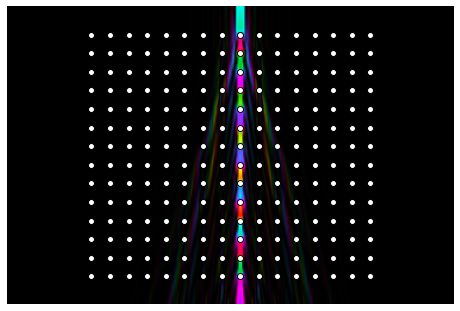

In [647]:
# STEM probe hitting a block of atoms
plot_wavefunction_atoms(
    STEM_probe(
        probe_max_inv_ang = 1.0,
        probe_pos = 20.0,
        probe_tilt = 0,
    ),
    atom_num = (14,16),   # (1,16),
    atom_shift = (0,0),  #(-120,0),
    atom_dxy = (16,16),
    atom_radius = 2,
    atom_phase = np.pi/4,
    amp_range=(0,0.5), 
    )

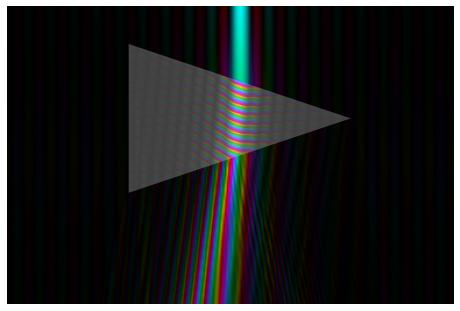

In [648]:
# STEM probe hitting an ideal phase wedge
plot_wavefunction_phase_wedge(
    STEM_probe(
        probe_max_inv_ang = 0.5,
        probe_pos = 20.0,
        probe_tilt = 0,
    ),
    phase_shift=np.pi/4,
    wedge_width=192,
    wedge_height=128,
    wedge_pos=(96,200),
    amp_range=(0,1), 
    amp_power=1, 
)

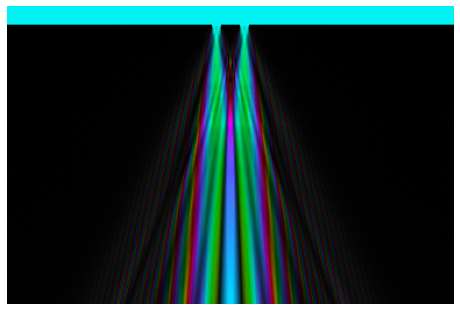

In [649]:
# Plane wave hitting a double-slit
plot_image(color_complex(wavefunction_prop(
    make_diffraction_grating(
        gap_num=2, 
        gap_spacing=24, 
        gap_size = 8),
    normalize_rows_max=True)))

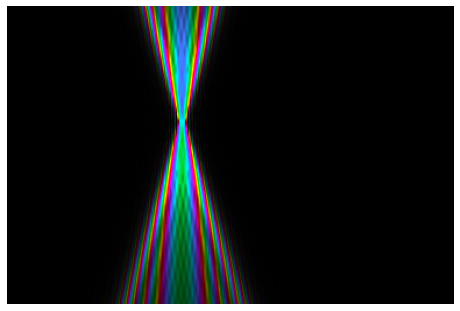

In [656]:
# Free space STEM probe (defocus)
plot_image(color_complex(wavefunction_prop(
    make_free_space(),
    STEM_probe(
        probe_max_inv_ang = 2.0,
        probe_pos = 15.0,
        probe_tilt = 2,
    ),
    defocus=1e4,
    normalize_rows_max=False),amp_range=(0,0.25),amp_power=2))

### Simple Examples

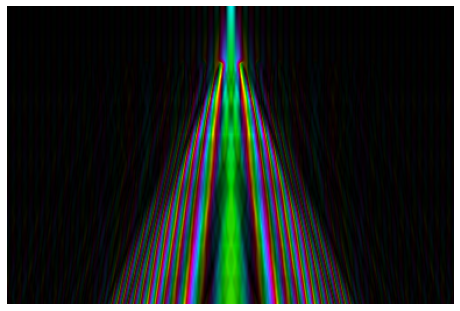

In [505]:
plot_image(color_complex(wavefunction_prop(
    make_atoms_block(atom_shift=(-80,0)),
    STEM_probe(probe_max_inv_ang=1.0),
    normalize_rows_max=True),
    amp_range=(0,1)))

In [565]:
plot_image(color_complex(wavefunction_prop(
    make_phase_wedge(phase_shift=np.pi/2),
    STEM_probe(probe_max_inv_ang=1),
    normalize_rows_max=True)))

NameError: name 'x_inds' is not defined

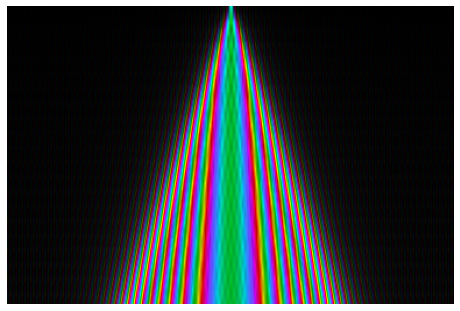

In [314]:
plot_image(color_complex(wavefunction_prop(
    np.ones((256,384)),
    STEM_probe(probe_max_inv_ang=2.0),
    normalize_rows_max=True)))

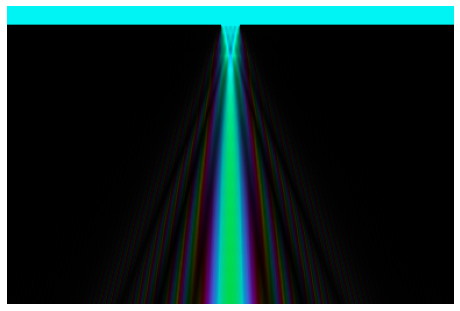

In [315]:
plot_image(color_complex(wavefunction_prop(
    make_diffraction_grating(gap_num=1, gap_size = 16),
    normalize_rows_max=True)))

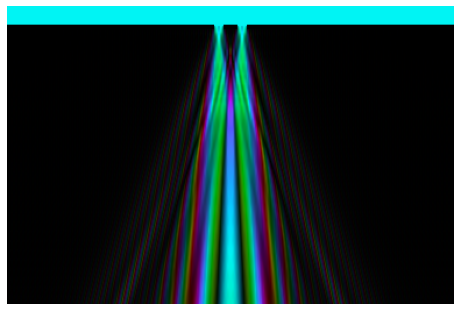

In [316]:
plot_image(color_complex(wavefunction_prop(
    make_diffraction_grating(gap_spacing = 20),
    normalize_rows_max=True)))

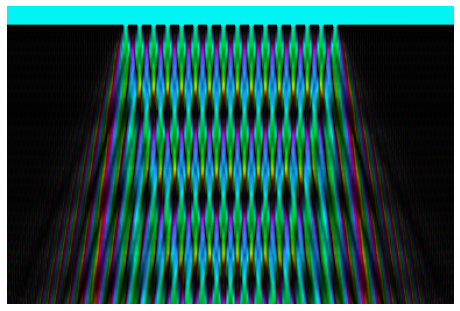

In [317]:
plot_image(color_complex(wavefunction_prop(
    make_diffraction_grating(gap_num=16, gap_spacing=12, gap_size = 4),
    normalize_rows_max=True)))